In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
import lmfit as lm
import scipy as sp
import corner
import emcee
import pandas as pd
from lc_lmfit import *

In [2]:
folder='afterglow_data/'
filename='_xray_batxrt.txt'

GRBs=['050724', '051227', '060614', '061006', '061210', '070714B', '071227', '080123', '080503', '111121A', '150424A', '211211A', '211227A']

In [ ]:
'060614', '080123','211211A', '211227A'

### Extracting and Plotting Curves


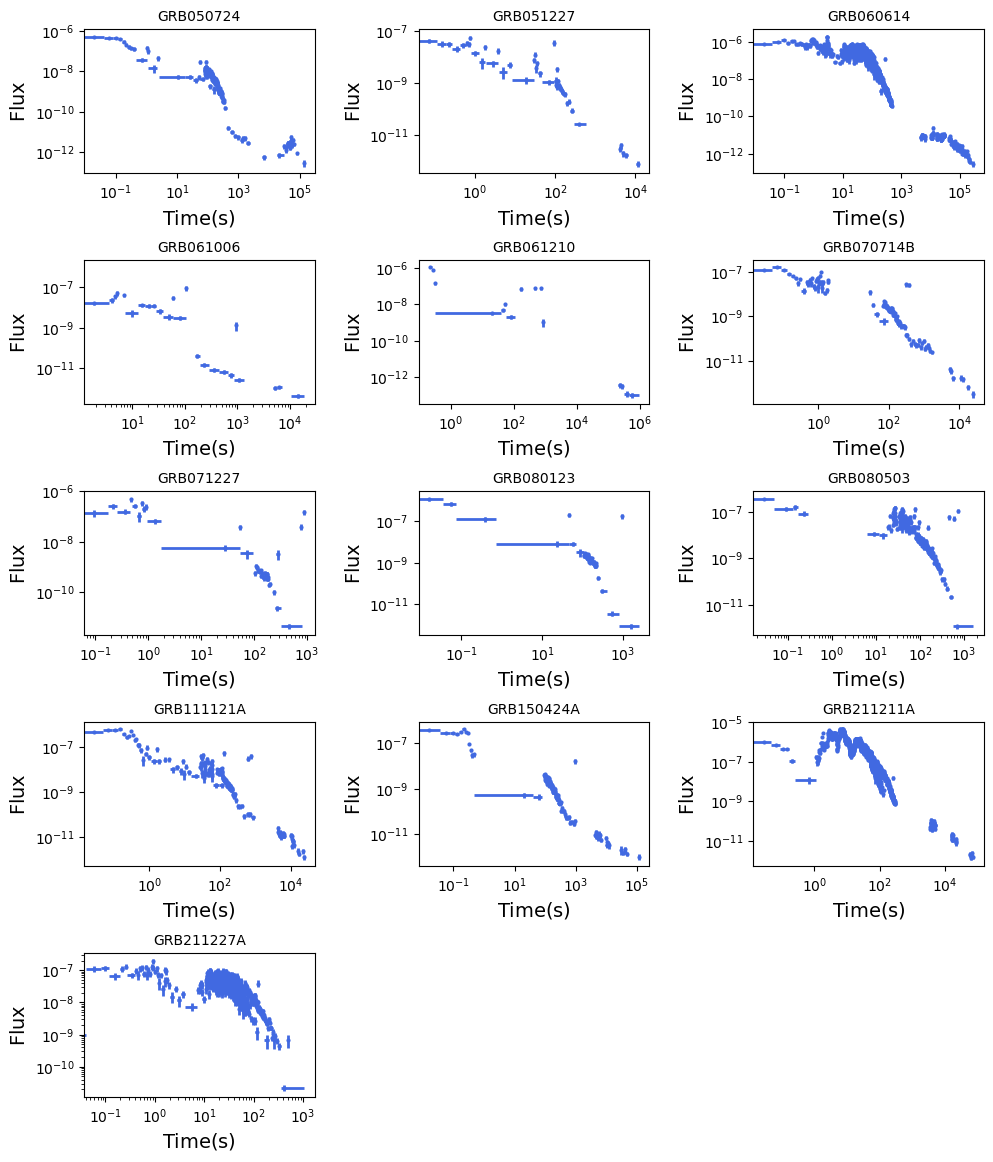

In [3]:
fig=plt.figure(figsize=(10.0,12.0), dpi=100)
fig.patch.set_facecolor('white')
plt.subplots_adjust(top=0.96, bottom=0.07, left=0.07, right=0.97, hspace=0.6,wspace=0.45)

for i in range(len(GRBs)):
    ax1 = fig.add_subplot(5,3, i+1)
    Time,Time_high,Time_low,Flux,Flux_high,Flux_low=get_individual_curves_log(folder+GRBs[i]+filename)
    ax1.errorbar(Time,Flux,xerr=[Time_low,Time_high],yerr=[Flux_low,Flux_high],fmt='.',color='royalblue',linewidth=2.0,markersize=4.0)
    plt.gca().set_xscale("log")
    plt.gca().set_yscale("log")
    #ax1.set_xlim(1e1,1e5)
    #ax1.set_ylim(1e-14,1e-9)
    ax1.set_xlabel('$\mathrm{Time(s)}$',fontsize=14.)
    ax1.set_ylabel('$\mathrm{Flux}$',fontsize=14.)
    ax1.set_title("GRB"+GRBs[i],fontsize=10)

#xticks = ticker.LogLocator(numticks=4)
#ax1.xaxis.set_minor_locator(xticks)
#ax1.tick_params(axis='x', which='minor', labelsize=7.0)

plt.show()

### GRB i=0

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 100
    # data points      = 52
    # variables        = 4
    chi-square         = 214.034595
    reduced chi-square = 4.45905407
    Akaike info crit   = 81.5744850
    Bayesian info crit = 89.3794599
[[Variables]]
    t_break:    59658.9777 +/- 15749.7449 (26.40%) (init = 55000)
    alpha_1:   -0.82372217 +/- 0.56315064 (68.37%) (init = -1.2)
    alpha_2:    2.97252066 +/- 2.77925084 (93.50%) (init = 2.2)
    amplitude:  2.6315e-12 +/- 8.8564e-13 (33.65%) (init = 2e-12)
[[Correlations]] (unreported correlations are < 0.100)
    C(t_break, alpha_2)   = +0.7583
    C(alpha_1, amplitude) = -0.5591
    C(alpha_2, amplitude) = +0.4900
    C(t_break, amplitude) = +0.3006
    C(t_break, alpha_1)   = +0.2398


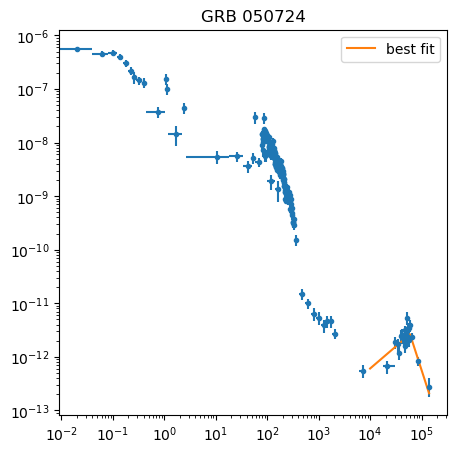

In [4]:
i=0
time,time_high,time_low,flux,flux_high,flux_low =get_individual_curves_log(folder+GRBs[i]+filename)
flux_err = flux_high + flux_low
time_err = time_high + time_low

fit_index = 211

params=lm.Parameters()
params.add("t_break", min = 4e4, max = 6e4, value = 5.5e4)
params.add("alpha_1", min = -5.0, max = 5.0, value = -1.2)
params.add("alpha_2", min = 0, max = 5.0, value = 2.2)
params.add("amplitude", min = 8e-13, max = 1e-11, value = 2e-12)

minner = lm.Minimizer(cost_func_bpl, params, fcn_args=(time[fit_index:], flux[fit_index:], time_err[fit_index:], flux_err[fit_index:]))
result = minner.minimize(method="least_squares")

bfit = result.params
tb = bfit["t_break"].value
alp1 = bfit["alpha_1"].value
alp2 = bfit["alpha_2"].value
amp = bfit["amplitude"].value

lm.printfuncs.report_fit(result)


x1=np.linspace(1e4,1.4e5,500)
fig=plt.figure(figsize=(5.0,5.0), dpi=100)
plt.errorbar(time, flux, fmt='.', xerr=[time_low,time_high],yerr=[flux_low,flux_high])
plt.plot(x1,broken_power_law(x1,tb, alp1, alp2, amp),label ='best fit')
#plt.errorbar(time[fit_index:], flux[fit_index:], fmt='o')
#plt.plot(x1,broken_power_law(x1,55000, -1.2, 2.2, 2e-12),label ='best fit')
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.title("GRB "+GRBs[i])
plt.show()

### Initial Emission

In [6]:
i=0
fig=plt.figure(figsize=(8.0,8.0), dpi=100)
fig.patch.set_facecolor('white')

fit_index = 211
params_ini=lm.Parameters()
params_ini.add("alpha_1", min = 0, max = 10.0, value = 2.7)
params_ini.add("amplitude", min = 1e-6, max = 1, value = 1e-3)

minner_ini = lm.Minimizer(cost_func_pl, params_ini, fcn_args=(time[:fit_index], flux[:fit_index], time_err[:fit_index], flux_err[:fit_index]))
result_ini = minner_ini.minimize(method="differential_evolution")

bfit_ini = result_ini.params
alp1_ini = bfit_ini["alpha_1"].value
amp_ini = bfit_ini["amplitude"].value

lm.printfuncs.report_fit(result_ini)

x1=np.linspace(7e1,2e3,30)
fig=plt.figure(figsize=(5.0,5.0), dpi=100)
plt.errorbar(time, flux, fmt='.', xerr=[time_low,time_high],yerr=[flux_low,flux_high])
# plt.plot(x1,power_law(x1,alp1_ini, amp_ini),label ='best fit')
plt.errorbar(time[:fit_index], flux[:fit_index], fmt='o')
plt.plot(x1,power_law(x1, 2.7, 1e-3),label ='best fit')
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.title("GRB "+GRBs[i])
plt.show()

/Users/kruthik/fxt_code/lc_lmfit.py:41: RuntimeWarning: invalid value encountered in power
  return amplitude * x ** (-alpha_1)


RuntimeError: The map-like callable must be of the form f(func, iterable), returning a sequence of numbers the same length as 'iterable'

<Figure size 800x800 with 0 Axes>

### nbroken law

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 142
    # data points      = 235
    # variables        = 10
    chi-square         = 116.666558
    reduced chi-square = 0.51851803
    Akaike info crit   = -144.562412
    Bayesian info crit = -109.966556
[[Variables]]
    tb0:        264.668895 +/- 4.08006895 (1.54%) (init = 250)
    tb1:        489.505872 +/- 23.7539090 (4.85%) (init = 450)
    tb2:        11995.9312 +/- 2967.28886 (24.74%) (init = 10000)
    tb3:        58695.3346 +/- 4779.85781 (8.14%) (init = 63000)
    alpha_0:    2.07486949 +/- 0.04437669 (2.14%) (init = 2)
    alpha_1:    7.47449921 +/- 0.42697906 (5.71%) (init = 8)
    alpha_2:    1.05512162 +/- 0.16541345 (15.68%) (init = 1)
    alpha_3:   -1.28203581 +/- 0.32840403 (25.62%) (init = -1.2)
    alpha_4:    3.08082001 +/- 0.96137089 (31.21%) (init = 2.5)
    amplitude:  8.2451e-10 +/- 4.4446e-11 (5.39%) (init = 8e-10)
[[Correlations]] (unreported correlations are < 0.100)
    C(

name,value,standard error,relative error,initial value,min,max,vary
tb0,264.668895,4.08006895,(1.54%),250.0,100.000000,1000.00000,True
tb1,489.505872,23.7539090,(4.85%),450.0,100.000000,1000.00000,True
tb2,11995.9312,2967.28886,(24.74%),10000.0,5000.00000,50000.0000,True
tb3,58695.3346,4779.85781,(8.14%),63000.0,40000.0000,90000.0000,True
alpha_0,2.07486949,0.04437669,(2.14%),2.0,-10.0000000,10.0000000,True
alpha_1,7.47449921,0.42697906,(5.71%),8.0,-10.0000000,20.0000000,True
alpha_2,1.05512162,0.16541345,(15.68%),1,-100.000000,100.000000,True
alpha_3,-1.28203581,0.32840403,(25.62%),-1.2,-5.00000000,0.00000000,True
alpha_4,3.08082001,0.96137089,(31.21%),2.5,0.00000000,10.0000000,True
amplitude,8.2451e-10,4.4446e-11,(5.39%),8e-10,1.0000e-10,5.0000e-09,True


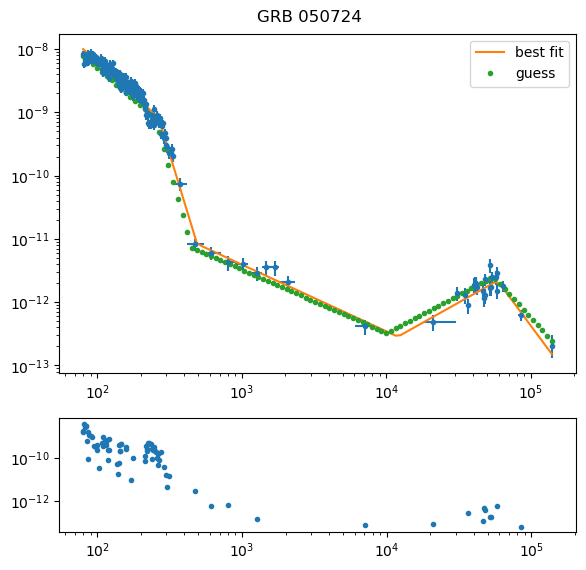

In [47]:
i=0
time,time_high,time_low,flux,flux_high,flux_low =get_individual_curves_log(folder+GRBs[i]+filename)
flux_err = flux_high + flux_low
time_err = time_high + time_low

fit_index = 0
n=5
params=lm.Parameters()
params.add("tb0", min = 1e2, max = 1e3, value = 2.5e2)
params.add("tb1", min = 1e2, max = 1e3, value = 4.5e2)
# params.add("tb2", min = 1e3, max = 5e3, value = 2e3)
params.add("tb2", min = 5e3, max = 5e4, value = 1e4)
params.add("tb3", min = 4e4, max = 9e4, value = 6.3e4)
params.add("alpha_0", min = -10, max = 10.0, value = 2.0)
params.add("alpha_1", min = -10, max = 20.0, value = 8.0)
params.add("alpha_2", min = -100, max = 100, value = 1)
# params.add("alpha_3", min = -100, max = 100, value = 1.4)
params.add("alpha_3", min = -5.0, max = 0, value = -1.2)
params.add("alpha_4", min = 0, max = 10.0, value = 2.5)
params.add("amplitude", min = 1e-10, max = 5e-9, value = 8e-10)

minner = lm.Minimizer(cost_func_nbpl, params, fcn_args=(time[fit_index:], flux[fit_index:], time_err[fit_index:], flux_err[fit_index:], n), fcn_kws={"orth":False})
result = minner.minimize(method="least_squares")
lm.printfuncs.report_fit(result)

residuals = get_y(result, n, time) - flux

x = np.geomspace(time[0],time[-1],100)
fig, (ax1, ax2) = plt.subplots(2, figsize=(20/3, 6), height_ratios=[3,1])
ax1.errorbar(time, flux, fmt='.', xerr=[time_low,time_high],yerr=[flux_low,flux_high])
ax1.loglog(x, get_y(result, n, x),label ='best fit')
# ax1.loglog(x, nbroken_law(x, [2.5e2, 5e2, 2e3, 1.5e4, 5.5e4], [2, 8.0, -0.2, 1.4, -2.2, 3.0], 8e-11),'.',label ='guess')
ax1.loglog(x, nbroken_law(x, [2.5e2, 4.5e2, 1e4, 5.5e4], [2, 8.0, 1, -1.2, 2.5], 8e-10),'.',label ='guess')
ax1.legend()
ax2.loglog(time,residuals, '.')
plt.subplots_adjust(top=0.94)
plt.suptitle("GRB "+GRBs[i])

result.params

In [22]:
result.params.valuesdict()

{'tb0': 264.6688951780947,
 'tb1': 489.50587245207925,
 'tb2': 11995.931242147362,
 'tb3': 58695.33461032089,
 'alpha_0': 2.0748694947703084,
 'alpha_1': 7.474499205260588,
 'alpha_2': 1.0551216222069375,
 'alpha_3': -1.2820358062489206,
 'alpha_4': 3.0808200067101525,
 'amplitude': 8.245143705801812e-10}